## Data Normalization / Preprocessing

### Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Preprocessing

In [26]:
class Data:
    def __init__(self):
        self.dataframe = pd.DataFrame([])

    def read(self, file_name: str):
        try:
            self.dataframe = pd.read_csv(file_name)
        except FileNotFoundError:
            print(f"File {file_name} not found.")
        except pd.errors.EmptyDataError:
            print("No data found in the file.")
        except Exception as e:
            print(f"An error occurred: {e}")

    def clean_data(self):
        """Remove null values"""
        self.dataframe = self.dataframe.dropna()

    def print_head(self):
        """Print the first few rows of the dataframe"""
        print(self.dataframe.head())

    def print_description(self):
        """Print the statistical description of the dataframe"""
        print(self.dataframe.describe())

    def normalization(self):
        """Normalize the data frame, excluding the Date column"""
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        numeric_columns = self.dataframe.select_dtypes(include=['float64', 'int64']).columns
        self.dataframe[numeric_columns] = self.scaler.fit_transform(self.dataframe[numeric_columns])

        # Separate scaler for 'Close' prices for LSTM
        self.close_scaler = MinMaxScaler(feature_range=(0, 1))
        self.dataframe['Close'] = self.close_scaler.fit_transform(self.dataframe[['Close']])

    def visualize_open(self):
        """Plot graph for open stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Open' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Open'], label='Open Stock Prices')
            plt.title('Open Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Open Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Open column not found in the dataframe")

    def visualize_close(self):
        """Plot graph for close stock values v/s date"""
        if 'Date' in self.dataframe.columns and 'Close' in self.dataframe.columns:
            self.dataframe['Date'] = pd.to_datetime(self.dataframe['Date'])
            plt.figure(figsize=(14, 7))
            plt.plot(self.dataframe['Date'], self.dataframe['Close'], label='Close Stock Prices')
            plt.title('Close Stock Prices Over Time')
            plt.xlabel('Date')
            plt.ylabel('Close Stock Price')
            plt.legend()
            plt.show()
        else:
            print("Date and/or Close column not found in the dataframe")

In [27]:
data = Data()

In [28]:
data.read('/content/AKG.csv')

In [29]:
data.clean_data()

In [30]:
data.print_head()
data.print_description()

         Date      Open      High       Low     Close  Adj Close  Volume
0  2018-10-10  9.133726  9.272116  9.133726  9.272116   9.272116   43355
1  2018-10-11  9.272116  9.272116  9.272116  9.272116   9.272116       0
2  2018-10-12  9.272116  9.272116  9.272116  9.272116   9.272116       0
3  2018-10-15  9.272116  9.272116  9.272116  9.272116   9.272116       0
4  2018-10-16  9.064531  9.064531  8.926142  8.995337   8.995337   43355
              Open         High          Low        Close    Adj Close  \
count  1387.000000  1387.000000  1387.000000  1387.000000  1387.000000   
mean     18.290741    18.671803    17.830421    18.232742    18.232742   
std       9.204636     9.435082     8.879798     9.171637     9.171637   
min       8.303388     8.303388     8.303388     8.303388     8.303388   
25%       9.659608     9.659608     9.597332     9.659608     9.659608   
50%      16.119644    16.662132    15.632511    16.119644    16.119644   
75%      25.519078    26.100000    24.775000

In [31]:
data.normalization()

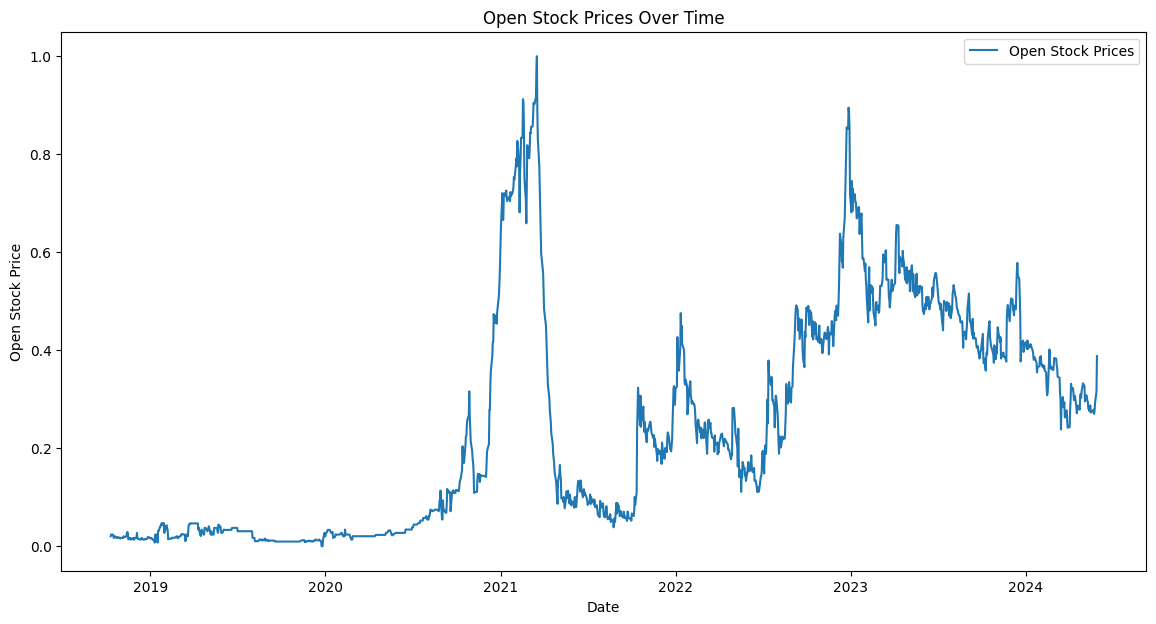

In [32]:
data.visualize_open()

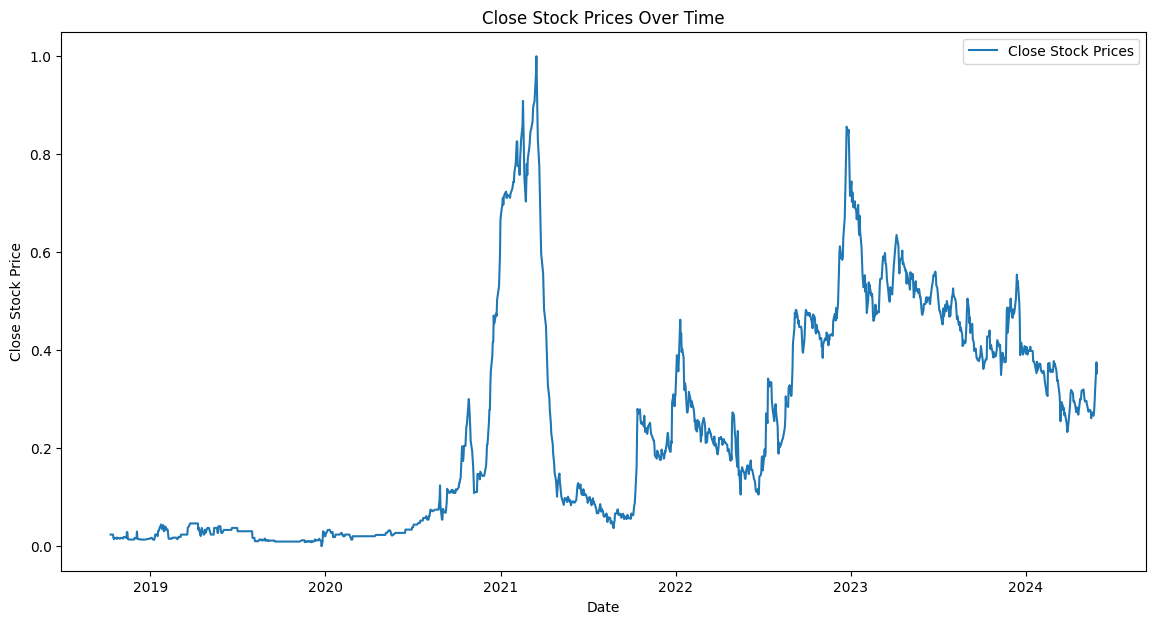

In [9]:
data.visualize_close()

## Model Training

### Imports

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
import numpy as np

### LSTM Model Training

In [33]:
class LSTMTrainer:
    def __init__(self, dataframe, scaler, close_scaler):
        self.dataframe = dataframe
        self.scaler = scaler
        self.close_scaler = close_scaler

    def prepare_data_for_lstm(self, feature_col='Close', look_back=60):
        """Prepare data for LSTM by creating sequences"""
        data = self.dataframe[feature_col].values
        data = data.reshape(-1, 1)
        X, y = [], []

        for i in range(len(data) - look_back):
            X.append(data[i:i + look_back])
            y.append(data[i + look_back])

        X, y = np.array(X), np.array(y)

        return train_test_split(X, y, test_size=0.2, shuffle=False)

    def build_and_train_lstm(self, feature_col='Close', look_back=60, epochs=50, batch_size=32):
        """Build and train the LSTM model"""
        X_train, X_test, y_train, y_test = self.prepare_data_for_lstm(feature_col, look_back)

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def predict_and_plot(self):
        """Make predictions and plot the results"""
        predictions = self.model.predict(self.X_test)
        predictions = self.close_scaler.inverse_transform(predictions)
        actual = self.close_scaler.inverse_transform(self.y_test.reshape(-1, 1))

        plt.figure(figsize=(14, 7))
        plt.plot(actual, label='Actual Stock Price')
        plt.plot(predictions, label='Predicted Stock Price')
        plt.title('Actual vs Predicted Stock Prices')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()

In [34]:
trainer = LSTMTrainer(data.dataframe, data.scaler, data.close_scaler)

In [35]:
trainer.build_and_train_lstm()

Epoch 1/50
34/34 [==============================] - 5s 45ms/step - loss: 0.0159 - val_loss: 0.0023
Epoch 2/50
34/34 [==============================] - 1s 15ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 3/50
34/34 [==============================] - 1s 15ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
34/34 [==============================] - 0s 13ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/50
34/34 [==============================] - 0s 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 7/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 9.9037e-04
Epoch 10/50
34/34 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 8.7485e-04
E

9/9 [==============================] - 1s 5ms/step


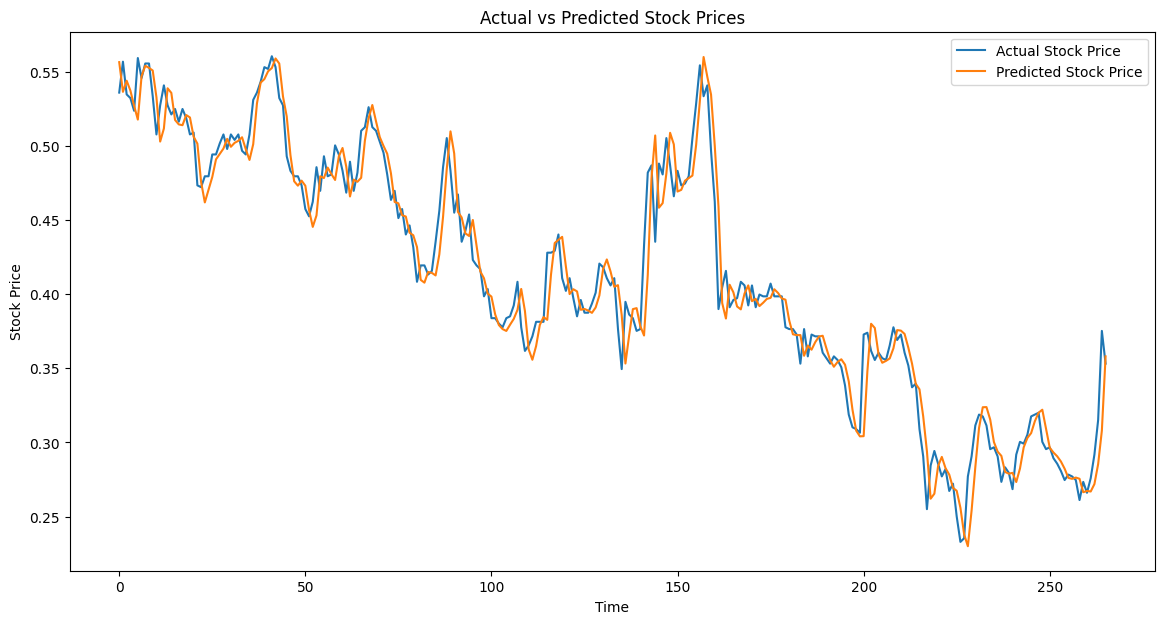

In [36]:
trainer.predict_and_plot()